## Experimenting with different LLMs - GPT-4 vs Claude-2

**Overview**: In this notebook, we will compare different LLM providers - specifically GPT-4 vs Claude-2. We will be using around 30 randomly picked examples from the Financial QA dataset and evaluate the response on different criteria to determine which of the two models performs better.
There are total 6 evals, we have covered in this notebook:
- Response Conciseness
- Response Match   (Against human annotated GT)
- Factual Accuracy
- Response Completeness with respect to Context
- Response Relevance

Each score has a value between 0 and 1. 

In [1]:
!pip install anthropic
!pip install openai
!pip install uptrain

  Using cached h11-0.14.0-py3-none-any.whl (58 kB)
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Successfully uninstalled h11-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
uptrain-server 0.1 requires fsspec>=2023.6.0, but you have fsspec 2023.5.0 which is incompatible.
  Using cached h11-0.14.0-py3-none-any.whl (58 kB)
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Successfully uninstalled h11-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
uptrain-server 0.1 requires fsspec>=2023.6.0, but you have fsspec 2023.5.0 which is incompatible.


### Authentication 

Let's define the required api keys - mainly the openai key (for generating responses), anthropic api key (for generating responses) and uptrain api key (for evaluating responses). You can create an account with UpTrain and generate the api key for free. Please visit https://uptrain.ai/

In [2]:
import polars as pl 
import os

from uptrain import APIClient, Evals, ResponseMatching
import openai
from anthropic import Anthropic

UPTRAIN_API_KEY = "up-*******************"
openai.api_key = "sk-*****************"
anthropic = Anthropic(api_key="sk-ant-****************")

### Download the testing dataset

Note: Ground Truth is optional as UpTrain supports many checks (like factual accuracy, response relevance, etc. which doesn't require ground truth)

In [3]:
url = "https://uptrain-assets.s3.ap-south-1.amazonaws.com/data/benchmark.jsonl"
dataset_path = os.path.join('./', "benchmark.jsonl")

if not os.path.exists(dataset_path):
    import httpx
    r = httpx.get(url)
    with open(dataset_path, "wb") as f:
        f.write(r.content)  

dataset = pl.read_ndjson(dataset_path).select(pl.col(["question", "ground_truth", "context"]))
print(dataset)

shape: (30, 3)
┌────────────────────────────────┬────────────────────────────────┬────────────────────────────────┐
│ question                       ┆ ground_truth                   ┆ context                        │
│ ---                            ┆ ---                            ┆ ---                            │
│ str                            ┆ str                            ┆ str                            │
╞════════════════════════════════╪════════════════════════════════╪════════════════════════════════╡
│ Do the activities of my LLC    ┆ No. When you file your         ┆ It really depends on the type  │
│ need…                          ┆ Articles …                     ┆ of…                            │
│ How much house can I afford,   ┆ On $4K/mo gross about $1000/mo ┆ There is no simple way to      │
│ wai…                           ┆ c…                             ┆ calcul…                        │
│ Will Short Sale Prevent Me     ┆ From MyFICO: A foreclosure     ┆ No that 

### Let's define a simple prompt to generate responses

In [4]:
def get_response(row, model):
    question = row['question'][0]
    context = row['context'][0]
    prompt = f"""
        Answer the following user query using the retrieved document in less than 3 sentences:
        {question}
        The retrieved document has the following text:
        {context}

        Answer:
    """

    if "gpt" in model:
        response = openai.ChatCompletion.create(
            model=model, messages=[{"role": "system", "content": prompt}]
        ).choices[0]["message"]["content"]
    elif "claude" in model:
        response = anthropic.completions.create(
            model=model,
            prompt=f"\n\nHuman:{prompt}\n\nAssistant:",
            max_tokens_to_sample=1000,
        ).completion
    
    return {'question': question, 'context': context, 'response': response, 'ground_truth': row['ground_truth'][0], 'model': model}

### Generate responses for both the models

In [5]:
results_oai = [get_response(dataset[idx], 'gpt-3.5-turbo') for idx in range(len(dataset))]
results_anthropic = [get_response(dataset[idx], 'claude-2') for idx in range(len(dataset))]

### Evaluating Experiments using UpTrain

UpTrain's APIClient provides an "evaluate_experiments" method which takes the input data to be evaluated along with the list of checks to be run and the name of the columns associated with the experiment. In this example, we are generating responses in the notebook itself but you can imagine generating responses via your own setup and just passing the query-response pair to UpTrain for evaluation 

In [9]:
from uptrain import APIClient, Evals, ResponseMatching
eval_client = APIClient(uptrain_api_key = UPTRAIN_API_KEY)

res = eval_client.evaluate_experiments(
    project_name = "GPT-vs-Claude-Experiments",
    data = results_oai + results_anthropic,
    checks = [
       Evals.RESPONSE_CONCISENESS,
       ResponseMatching(method='llm'),  # Comment this if you don't have Ground Truth
       Evals.RESPONSE_COMPLETENESS_WRT_CONTEXT,
       Evals.FACTUAL_ACCURACY,
    ],
    exp_columns=['model']
)

2023-11-21 12:46:18.063 | INFO     | uptrain.framework.remote:log_and_evaluate:455 - Sending evaluation request for rows 0 to <50 to the Uptrain server
2023-11-21 12:47:40.259 | INFO     | uptrain.framework.remote:log_and_evaluate:455 - Sending evaluation request for rows 50 to <100 to the Uptrain server


**Access UpTrain Dashboards**: We can access the evaluation results at https://demo.uptrain.ai/dashboard/ - the same API key can be used to access the dashboards. 

As we can see below, Claude-2 provides more concise and complete responses as compared to GPT-3.5-turbo, rendering them better for the given use-case.

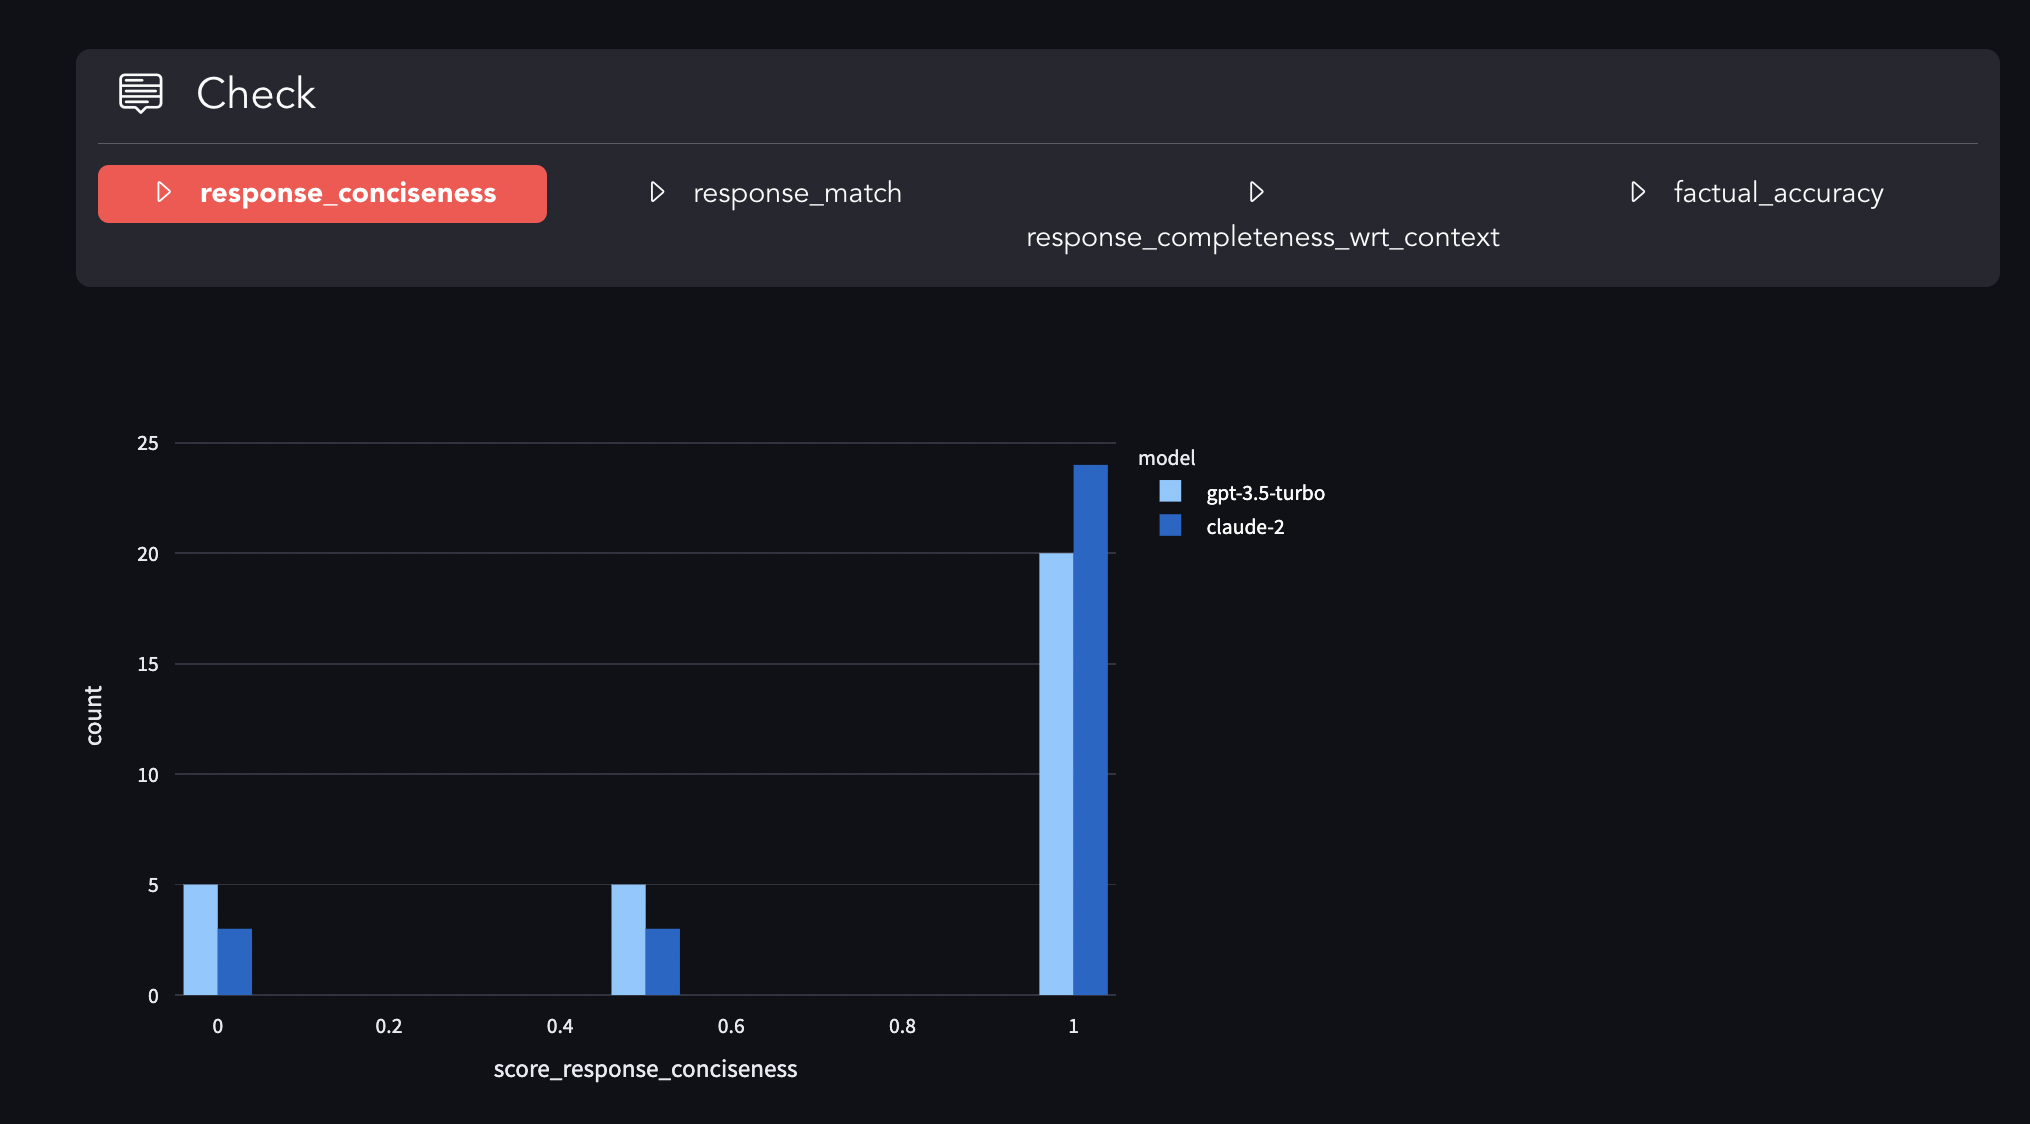

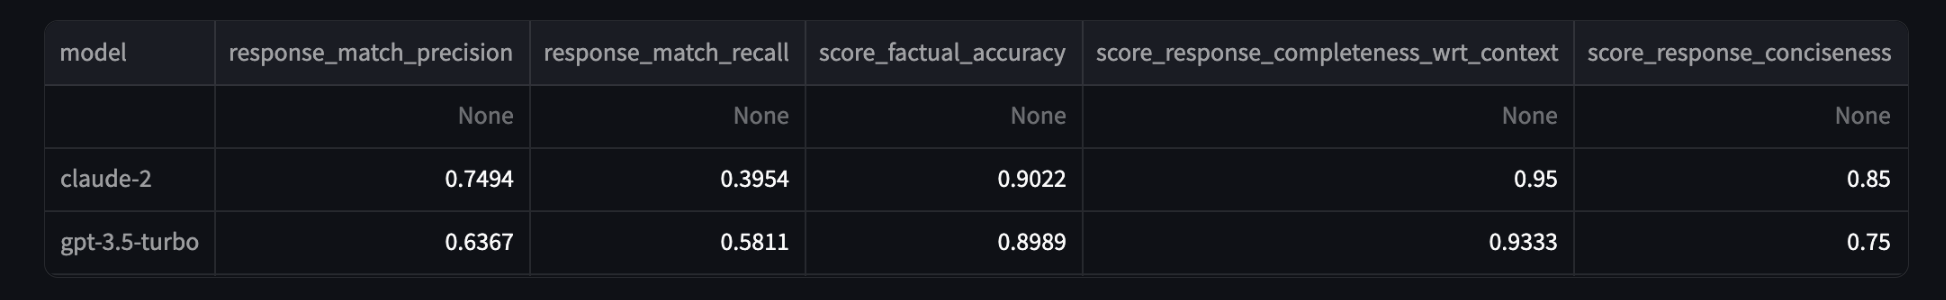